# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.9/500.9 KB 12.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 KB 5.4 MB/s eta 0:00:0000:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 KB 12.8 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 KB 3.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 8.5 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [20]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [27]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [28]:
client = MongoClient(mongod_connect)
db = client.lab9 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [29]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [30]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [31]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [32]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [33]:
count = 100 #number of returned tweets, default and max is 100
geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "election"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [34]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Wed Nov 09 21:32:53 +0000 2022'
'Wed Nov 09 21:20:26 +0000 2022'
'Wed Nov 09 21:16:05 +0000 2022'
'Wed Nov 09 21:14:10 +0000 2022'
'Wed Nov 09 21:13:11 +0000 2022'
'Wed Nov 09 21:13:04 +0000 2022'
'Wed Nov 09 21:12:12 +0000 2022'
'Wed Nov 09 21:10:35 +0000 2022'
'Wed Nov 09 21:03:24 +0000 2022'
'Wed Nov 09 21:01:16 +0000 2022'
'Wed Nov 09 21:01:02 +0000 2022'
'Wed Nov 09 20:50:46 +0000 2022'
'Wed Nov 09 20:49:20 +0000 2022'
'Wed Nov 09 20:43:36 +0000 2022'
'Wed Nov 09 20:36:37 +0000 2022'
'Wed Nov 09 20:32:45 +0000 2022'
'Wed Nov 09 20:26:26 +0000 2022'
'Wed Nov 09 20:24:07 +0000 2022'
'Wed Nov 09 20:22:45 +0000 2022'
'Wed Nov 09 20:21:03 +0000 2022'
'Wed Nov 09 20:08:04 +0000 2022'
'Wed Nov 09 20:06:47 +0000 2022'
'Wed Nov 09 20:06:07 +0000 2022'
'Wed Nov 09 20:05:01 +0000 2022'
'Wed Nov 09 19:54:02 +0000 2022'
'Wed Nov 09 19:51:02 +0000 2022'
'Wed Nov 09 19:49:02 +0000 2022'
'Wed Nov 09 19:44:26 +0000 2022'
'Wed Nov 09 19:39:25 +0000 2022'
'Wed Nov 09 19:39:25 +0000 2022'
'Wed Nov 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [35]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Wed Nov 09 16:57:17 +0000 2022'
'Wed Nov 09 16:56:21 +0000 2022'
'Wed Nov 09 16:56:13 +0000 2022'
'Wed Nov 09 16:49:10 +0000 2022'
'Wed Nov 09 16:48:47 +0000 2022'
'Wed Nov 09 16:47:58 +0000 2022'
'Wed Nov 09 16:44:48 +0000 2022'
'Wed Nov 09 16:42:21 +0000 2022'
'Wed Nov 09 16:40:13 +0000 2022'
'Wed Nov 09 16:37:54 +0000 2022'
'Wed Nov 09 16:37:43 +0000 2022'
'Wed Nov 09 16:35:14 +0000 2022'
'Wed Nov 09 16:33:54 +0000 2022'
'Wed Nov 09 16:33:40 +0000 2022'
'Wed Nov 09 16:30:40 +0000 2022'
'Wed Nov 09 16:29:42 +0000 2022'
'Wed Nov 09 16:27:48 +0000 2022'
'Wed Nov 09 16:24:57 +0000 2022'
'Wed Nov 09 16:23:46 +0000 2022'
'Wed Nov 09 16:23:44 +0000 2022'
'Wed Nov 09 16:23:02 +0000 2022'
'Wed Nov 09 16:21:32 +0000 2022'
'Wed Nov 09 16:20:28 +0000 2022'
'Wed Nov 09 16:20:17 +0000 2022'
'Wed Nov 09 16:18:56 +0000 2022'
'Wed Nov 09 16:14:28 +0000 2022'
'Wed Nov 09 16:13:48 +0000 2022'
'Wed Nov 09 16:12:08 +0000 2022'
'Wed Nov 09 16:06:12 +0000 2022'
'Wed Nov 09 16:01:50 +0000 2022'
'Wed Nov 0

'Wed Nov 09 04:13:11 +0000 2022'
'Wed Nov 09 04:11:00 +0000 2022'
'Wed Nov 09 04:09:55 +0000 2022'
'Wed Nov 09 04:04:19 +0000 2022'
'Wed Nov 09 04:03:01 +0000 2022'
'Wed Nov 09 04:01:33 +0000 2022'
'Wed Nov 09 03:57:11 +0000 2022'
'Wed Nov 09 03:57:05 +0000 2022'
'Wed Nov 09 03:56:07 +0000 2022'
'Wed Nov 09 03:55:29 +0000 2022'
'Wed Nov 09 03:53:27 +0000 2022'
'Wed Nov 09 03:51:34 +0000 2022'
'Wed Nov 09 03:48:21 +0000 2022'
'Wed Nov 09 03:46:21 +0000 2022'
'Wed Nov 09 03:46:08 +0000 2022'
'Wed Nov 09 03:41:32 +0000 2022'
'Wed Nov 09 03:41:11 +0000 2022'
'Wed Nov 09 03:40:38 +0000 2022'
'Wed Nov 09 03:40:27 +0000 2022'
'Wed Nov 09 03:39:49 +0000 2022'
'Wed Nov 09 03:39:19 +0000 2022'
'Wed Nov 09 03:37:43 +0000 2022'
'Wed Nov 09 03:36:48 +0000 2022'
'Wed Nov 09 03:36:48 +0000 2022'
'Wed Nov 09 03:36:25 +0000 2022'
'Wed Nov 09 03:35:29 +0000 2022'
'Wed Nov 09 03:31:03 +0000 2022'
'Wed Nov 09 03:31:02 +0000 2022'
'Wed Nov 09 03:29:31 +0000 2022'
'Wed Nov 09 03:28:24 +0000 2022'
'Wed Nov 0

'Tue Nov 08 21:45:07 +0000 2022'
'Tue Nov 08 21:45:03 +0000 2022'
'Tue Nov 08 21:42:51 +0000 2022'
'Tue Nov 08 21:35:57 +0000 2022'
'Tue Nov 08 21:35:21 +0000 2022'
'Tue Nov 08 21:35:06 +0000 2022'
'Tue Nov 08 21:34:28 +0000 2022'
'Tue Nov 08 21:31:40 +0000 2022'
'Tue Nov 08 21:31:29 +0000 2022'
'Tue Nov 08 21:30:15 +0000 2022'
'Tue Nov 08 21:29:33 +0000 2022'
'Tue Nov 08 21:29:09 +0000 2022'
'Tue Nov 08 21:28:46 +0000 2022'
'Tue Nov 08 21:27:51 +0000 2022'
'Tue Nov 08 21:23:50 +0000 2022'
'Tue Nov 08 21:21:21 +0000 2022'
'Tue Nov 08 21:12:25 +0000 2022'
'Tue Nov 08 21:11:12 +0000 2022'
'Tue Nov 08 21:07:01 +0000 2022'
'Tue Nov 08 21:05:21 +0000 2022'
'Tue Nov 08 21:04:10 +0000 2022'
'Tue Nov 08 21:03:44 +0000 2022'
'Tue Nov 08 21:02:42 +0000 2022'
'Tue Nov 08 21:01:23 +0000 2022'
'Tue Nov 08 21:01:09 +0000 2022'
'Tue Nov 08 21:00:53 +0000 2022'
'Tue Nov 08 21:00:28 +0000 2022'
'Tue Nov 08 20:59:28 +0000 2022'
'Tue Nov 08 20:56:56 +0000 2022'
'Tue Nov 08 20:55:33 +0000 2022'
'Tue Nov 0

'Tue Nov 08 14:08:18 +0000 2022'
'Tue Nov 08 14:06:58 +0000 2022'
'Tue Nov 08 14:06:29 +0000 2022'
'Tue Nov 08 14:05:31 +0000 2022'
'Tue Nov 08 14:04:59 +0000 2022'
'Tue Nov 08 14:03:56 +0000 2022'
'Tue Nov 08 14:03:13 +0000 2022'
'Tue Nov 08 14:00:17 +0000 2022'
'Tue Nov 08 14:00:02 +0000 2022'
'Tue Nov 08 13:59:56 +0000 2022'
'Tue Nov 08 13:58:56 +0000 2022'
'Tue Nov 08 13:58:34 +0000 2022'
'Tue Nov 08 13:58:03 +0000 2022'
'Tue Nov 08 13:57:58 +0000 2022'
'Tue Nov 08 13:57:52 +0000 2022'
'Tue Nov 08 13:54:48 +0000 2022'
'Tue Nov 08 13:54:10 +0000 2022'
'Tue Nov 08 13:51:25 +0000 2022'
'Tue Nov 08 13:49:52 +0000 2022'
'Tue Nov 08 13:48:36 +0000 2022'
'Tue Nov 08 13:47:32 +0000 2022'
'Tue Nov 08 13:47:15 +0000 2022'
'Tue Nov 08 13:46:56 +0000 2022'
'Tue Nov 08 13:46:45 +0000 2022'
'Tue Nov 08 13:45:36 +0000 2022'
'Tue Nov 08 13:44:47 +0000 2022'
'Tue Nov 08 13:44:14 +0000 2022'
'Tue Nov 08 13:44:06 +0000 2022'
'Tue Nov 08 13:44:04 +0000 2022'
'Tue Nov 08 13:43:31 +0000 2022'
'Tue Nov 0

'Mon Nov 07 21:09:04 +0000 2022'
'Mon Nov 07 21:06:52 +0000 2022'
'Mon Nov 07 21:06:50 +0000 2022'
'Mon Nov 07 21:01:03 +0000 2022'
'Mon Nov 07 21:00:36 +0000 2022'
'Mon Nov 07 20:59:29 +0000 2022'
'Mon Nov 07 20:56:45 +0000 2022'
'Mon Nov 07 20:53:07 +0000 2022'
'Mon Nov 07 20:48:19 +0000 2022'
'Mon Nov 07 20:45:55 +0000 2022'
'Mon Nov 07 20:40:35 +0000 2022'
'Mon Nov 07 20:37:27 +0000 2022'
'Mon Nov 07 20:37:24 +0000 2022'
'Mon Nov 07 20:37:10 +0000 2022'
'Mon Nov 07 20:35:28 +0000 2022'
'Mon Nov 07 20:34:32 +0000 2022'
'Mon Nov 07 20:33:59 +0000 2022'
'Mon Nov 07 20:30:27 +0000 2022'
'Mon Nov 07 20:27:28 +0000 2022'
'Mon Nov 07 20:25:07 +0000 2022'
'Mon Nov 07 20:21:18 +0000 2022'
'Mon Nov 07 20:21:16 +0000 2022'
'Mon Nov 07 20:19:50 +0000 2022'
'Mon Nov 07 20:19:02 +0000 2022'
'Mon Nov 07 20:18:03 +0000 2022'
'Mon Nov 07 20:12:00 +0000 2022'
'Mon Nov 07 20:02:44 +0000 2022'
'Mon Nov 07 20:01:18 +0000 2022'
'Mon Nov 07 19:58:39 +0000 2022'
'Mon Nov 07 19:39:24 +0000 2022'
'Mon Nov 0

'Sun Nov 06 15:58:10 +0000 2022'
'Sun Nov 06 15:56:11 +0000 2022'
'Sun Nov 06 15:35:05 +0000 2022'
'Sun Nov 06 15:30:55 +0000 2022'
'Sun Nov 06 15:29:19 +0000 2022'
'Sun Nov 06 15:27:29 +0000 2022'
'Sun Nov 06 15:27:04 +0000 2022'
'Sun Nov 06 15:02:03 +0000 2022'
'Sun Nov 06 14:58:32 +0000 2022'
'Sun Nov 06 14:51:51 +0000 2022'
'Sun Nov 06 14:50:27 +0000 2022'
'Sun Nov 06 14:48:12 +0000 2022'
'Sun Nov 06 14:45:26 +0000 2022'
'Sun Nov 06 14:43:27 +0000 2022'
'Sun Nov 06 14:29:12 +0000 2022'
'Sun Nov 06 14:27:57 +0000 2022'
'Sun Nov 06 14:20:30 +0000 2022'
'Sun Nov 06 13:55:24 +0000 2022'
'Sun Nov 06 13:45:37 +0000 2022'
'Sun Nov 06 13:31:06 +0000 2022'
'Sun Nov 06 13:13:46 +0000 2022'
'Sun Nov 06 12:41:25 +0000 2022'
'Sun Nov 06 12:16:13 +0000 2022'
'Sun Nov 06 11:13:29 +0000 2022'
'Sun Nov 06 11:11:57 +0000 2022'
'Sun Nov 06 11:03:48 +0000 2022'
'Sun Nov 06 11:00:33 +0000 2022'
'Sun Nov 06 10:28:58 +0000 2022'
'Sun Nov 06 10:04:21 +0000 2022'
'Sun Nov 06 09:36:19 +0000 2022'
'Sun Nov 0

'Fri Nov 04 16:07:53 +0000 2022'
'Fri Nov 04 16:02:19 +0000 2022'
'Fri Nov 04 16:00:47 +0000 2022'
'Fri Nov 04 15:52:36 +0000 2022'
'Fri Nov 04 15:48:48 +0000 2022'
'Fri Nov 04 15:47:21 +0000 2022'
'Fri Nov 04 15:37:33 +0000 2022'
'Fri Nov 04 15:35:53 +0000 2022'
'Fri Nov 04 15:32:11 +0000 2022'
'Fri Nov 04 15:31:03 +0000 2022'
'Fri Nov 04 15:21:48 +0000 2022'
'Fri Nov 04 15:19:44 +0000 2022'
'Fri Nov 04 15:14:23 +0000 2022'
'Fri Nov 04 15:13:14 +0000 2022'
'Fri Nov 04 15:08:40 +0000 2022'
'Fri Nov 04 15:03:24 +0000 2022'
'Fri Nov 04 15:03:04 +0000 2022'
'Fri Nov 04 15:00:17 +0000 2022'
'Fri Nov 04 15:00:09 +0000 2022'
'Fri Nov 04 14:57:55 +0000 2022'
'Fri Nov 04 14:48:04 +0000 2022'
'Fri Nov 04 14:38:43 +0000 2022'
'Fri Nov 04 14:27:17 +0000 2022'
'Fri Nov 04 14:23:44 +0000 2022'
'Fri Nov 04 14:17:18 +0000 2022'
'Fri Nov 04 14:04:17 +0000 2022'
'Fri Nov 04 14:00:52 +0000 2022'
'Fri Nov 04 14:00:05 +0000 2022'
'Fri Nov 04 14:00:04 +0000 2022'
'Fri Nov 04 13:59:01 +0000 2022'
'Fri Nov 0

'Thu Nov 03 10:14:47 +0000 2022'
'Thu Nov 03 09:44:07 +0000 2022'
'Thu Nov 03 08:24:19 +0000 2022'
'Thu Nov 03 07:58:48 +0000 2022'
'Thu Nov 03 07:52:35 +0000 2022'
'Thu Nov 03 07:42:17 +0000 2022'
'Thu Nov 03 07:01:53 +0000 2022'
'Thu Nov 03 06:43:12 +0000 2022'
'Thu Nov 03 06:15:25 +0000 2022'
'Thu Nov 03 06:08:52 +0000 2022'
'Thu Nov 03 06:01:24 +0000 2022'
'Thu Nov 03 05:32:18 +0000 2022'
'Thu Nov 03 05:28:33 +0000 2022'
'Thu Nov 03 04:51:56 +0000 2022'
'Thu Nov 03 04:46:05 +0000 2022'
'Thu Nov 03 04:32:39 +0000 2022'
'Thu Nov 03 04:31:55 +0000 2022'
'Thu Nov 03 04:25:39 +0000 2022'
'Thu Nov 03 04:23:04 +0000 2022'
'Thu Nov 03 04:10:01 +0000 2022'
'Thu Nov 03 04:09:17 +0000 2022'
'Thu Nov 03 04:04:03 +0000 2022'
'Thu Nov 03 03:54:30 +0000 2022'
'Thu Nov 03 03:53:33 +0000 2022'
'Thu Nov 03 03:46:54 +0000 2022'
'Thu Nov 03 03:32:38 +0000 2022'
'Thu Nov 03 03:31:53 +0000 2022'
'Thu Nov 03 03:30:51 +0000 2022'
'Thu Nov 03 03:26:48 +0000 2022'
'Thu Nov 03 03:05:22 +0000 2022'
'Thu Nov 0

'Tue Nov 01 15:23:40 +0000 2022'
'Tue Nov 01 15:10:00 +0000 2022'
'Tue Nov 01 14:52:31 +0000 2022'
'Tue Nov 01 14:51:24 +0000 2022'
'Tue Nov 01 14:37:50 +0000 2022'
'Tue Nov 01 14:34:38 +0000 2022'
'Tue Nov 01 14:28:25 +0000 2022'
'Tue Nov 01 14:23:48 +0000 2022'
'Tue Nov 01 14:22:41 +0000 2022'
'Tue Nov 01 14:14:14 +0000 2022'
'Tue Nov 01 14:06:35 +0000 2022'
'Tue Nov 01 14:04:20 +0000 2022'
'Tue Nov 01 14:00:01 +0000 2022'
'Tue Nov 01 13:58:40 +0000 2022'
'Tue Nov 01 13:57:25 +0000 2022'
'Tue Nov 01 13:45:24 +0000 2022'
'Tue Nov 01 13:41:05 +0000 2022'
'Tue Nov 01 13:30:05 +0000 2022'
'Tue Nov 01 13:14:38 +0000 2022'
'Tue Nov 01 13:09:44 +0000 2022'
'Tue Nov 01 13:04:07 +0000 2022'
'Tue Nov 01 13:01:32 +0000 2022'
'Tue Nov 01 13:00:37 +0000 2022'
'Tue Nov 01 12:45:32 +0000 2022'
'Tue Nov 01 12:44:59 +0000 2022'
'Tue Nov 01 12:42:28 +0000 2022'
'Tue Nov 01 12:36:18 +0000 2022'
'Tue Nov 01 12:25:12 +0000 2022'
'Tue Nov 01 12:10:59 +0000 2022'
'Tue Nov 01 12:04:51 +0000 2022'
'Tue Nov 0

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [36]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

2248
1008


Create a text index and print the Tweets containing specific keywords. 

In [37]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [38]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [39]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Sheila
text: I voted!! Make your vote count and your voice to be heard! #voting #vote #election #elections2022 #votingrights… https://t.co/1WJNDgCUvl
----
name: Goldi Gaines
text: Vote  Vote Vote! Election Day is almost here and early Voting has already begun! To find a location near visit… https://t.co/DqlNi1ct98
----
name: 🇺🇸 Buck Joe Fiden 🇺🇸 ULTRA MAGA
text: @ProudElephantUS I vote on election day in person. Early voting and mail in voting is how they cheat!
----
name: IAFF Local 2498
text: Reminder to make plans to VOTE on November 8th 2022. or VOTE Early. EARLY VOTING IN-PERSON
You can vote early at yo… https://t.co/WX4b7B8uN3
----
name: JesseGibsonforAR
text: It’s Election Day in Arkansas!  Get out and vote, vote, VOTE!  #jg4ag #arpx. #arkansas https://t.co/0zCtq6wY9C
----
name: Ty Kinney
text: @LePetiteLeRoux The rest of the votes are from heavily Republican districts, or votes from people who voted today(R… https://t.co/ALDUFjeY9m
----
name: Madison Center for Civic

In [40]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [41]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,636c1cd316c7e0f25f3a783e,Tue Nov 08 14:43:36 +0000 2022,1589992036643512320,1589992036643512320,I voted!! Make your vote count and your voice ...,True,"{'hashtags': [{'text': 'voting', 'indices': [5...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
1,636c1cf416c7e0f25f3a7da8,Tue Nov 01 14:34:38 +0000 2022,1587453065728335873,1587453065728335873,Vote Vote Vote! Election Day is almost here a...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,18,27,False,False,False,en,NaN,NaN,NaN,NaN
2,636c1ce616c7e0f25f3a7b4d,Fri Nov 04 20:27:07 +0000 2022,1588628931737161729,1588628931737161729,@ProudElephantUS I vote on election day in per...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.588616e+18,...,0,4,False,False,NaN,en,NaN,NaN,NaN,NaN
3,636c1ce816c7e0f25f3a7b9e,Fri Nov 04 13:45:57 +0000 2022,1588527975531974656,1588527975531974656,Reminder to make plans to VOTE on November 8th...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,4,7,False,False,False,en,NaN,NaN,NaN,NaN
4,636c1cd616c7e0f25f3a7895,Tue Nov 08 13:04:30 +0000 2022,1589967097861312513,1589967097861312513,It’s Election Day in Arkansas! Get out and vo...,False,"{'hashtags': [{'text': 'jg4ag', 'indices': [63...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,44,145,False,False,False,en,"{'media': [{'id': 1589966908731834370, 'id_str...",NaN,NaN,NaN
5,636c1cc816c7e0f25f3a7643,Wed Nov 09 04:38:58 +0000 2022,1590202263532077056,1590202263532077056,@LePetiteLeRoux The rest of the votes are from...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.590202e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
6,636c1cdb16c7e0f25f3a795c,Mon Nov 07 21:09:04 +0000 2022,1589726652883668992,1589726652883668992,Episode 3 of the student-led Dukes Vote Podcas...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,2,False,False,False,en,NaN,NaN,NaN,NaN
7,636c1cdc16c7e0f25f3a7982,Mon Nov 07 18:57:40 +0000 2022,1589693583409352706,1589693583409352706,Say yes to voting. Tomorrow is Election Day ge...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,4,5,False,False,False,en,NaN,NaN,NaN,NaN
8,636c1cdb16c7e0f25f3a7964,Mon Nov 07 20:48:19 +0000 2022,1589721430534811649,1589721430534811649,GO VOTE TOMORROW! We have to win this election...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3,1,False,False,NaN,en,NaN,NaN,NaN,NaN
9,636c1ced16c7e0f25f3a7c63,Thu Nov 03 13:43:00 +0000 2022,1588164844632645634,1588164844632645634,Saturday voting this weekend. Saturday will be...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,4,4,False,False,False,en,NaN,NaN,NaN,NaN


<AxesSubplot:>

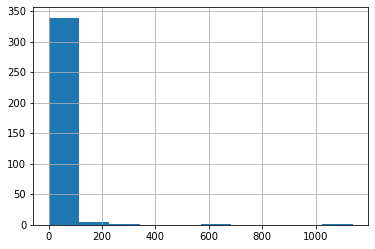

In [42]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count